# Data Imputation - How to Deal with Missing Data



Refs:
- https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation
- https://scikit-learn.org/stable/modules/impute.html
- https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
- https://www.residentmar.io/2016/06/12/null-and-missing-data-python.html
----

Missing data is a well-known problem in many data-related fields. Almost in every single project which contains data, in early stages of it we need to face the famous problem of "Dealing with Missing Data". This project is not an exception, so we have to face this problem, just before we move on to preparing our model. as you can see in the "Ads" sheet of our dataset, we have some missing data which we are going to solve in this notebook.

It's worth to mention that we are going to test different methods for this problem and choose the one which works the best for this case.

Most machine learning algorithms (except KNN) cannot deal with this problem intrinsically, as they are designed for complete data. so we have to do something regarding this matter.

Missing data can be categorized into two types:
- Data missing at random
- Data missing at not random

There are different approaches regarding the category of missing data.

>If the data are truly NMAR, then the missing data mechanism must be modeled as part of the estimation process in order to produce unbiased parameter estimates. That means that, if there is missing data on Y, one must specify how the probability that Y is missing depends on Y and on other variables. This is not straightforward because there are an infinite number of different models that one could specify. Nothing in the data will indicate which of these models is correct. And, unfortunately, results could be highly sensitive to the choice of model. A good deal of research has been devoted to the problem of data that are not missing at random, and some progress has been made. Unfortunately, the available methods are rather complex, even for very simple situations.

"Handling Missing Data by Maximum Likelihood"—Paul D. Allison, Statistical Horizons, Haverford, PA, USA


### Simple Approaches

#### Dropping rows with null values

The easiest and quickest approach to a missing data problem is dropping the offending entries. This is an acceptable solution if we are confident that the missing data in the dataset is missing at random, and if the number of data points we have access to is sufficiently high that dropping some of them will not cause us to lose generalizability in the models we build (to determine whether or not this is case, use a learning curve).

Dropping data missing not at random is dangerous. It will result in significant bias in your model in cases where data being absent corresponds with some real-world phenomenon. Because this requires domain knowledge, usually the only way to determine if this is a problem is through manual inspection.

Dropping too much data is also dangerous. It can create significant bias by depriving your algorithms of space. This is especially true of classifiers sensitive to the curse of dimensionality.

#### Dropping features with high nullity

A feature that has a high number of empty values is unlikely to be very useful for prediction. It can often be safely dropped.
Dropping rare features simplifies your model, but obviously gives you fewer features to work with. Before dropping features outright, consider subsetting the part of the dataset that this value is available for and checking its feature importance when it is used to train a model in this subset. If in doing so you disover that the variable is important in the subset it is defined, consider making an effort to retain it.

#### Mean or median or other summary statistic substitution

The remainder of the techniques available are imputation methods, as opposed to data-dropping methods. The simplest imputation method is replacing missing values with the mean or median values of the dataset at large, or some similar summary statistic. This has the advantage of being the simplest possible approach, and one that doesn't introduce any undue bias into the dataset. But:


> [However] with missing values that are not strictly random, especially in the presence of a great inequality in the number of missing values for the different variables, the mean substitution method may lead to inconsistent bias. Furthermore, this approach adds no new information but only increases the sample size and leads to an underestimate of the errors. Thus, mean substitution is not generally accepted.

Kang H. (2013). The prevention and handling of the missing data. Korean journal of anesthesiology, 64(5), 402–406. https://doi.org/10.4097/kjae.2013.64.5.402 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/



### Model Imputation

Here's a fun trick. To prepare a dataset for machine learning we need to fix missing values, and we can fix missing values by applying machine learning to that dataset! If we consider a column with missing data as our target variable, and existing columns with complete data as our predictor variables, then we may construct a machine learning model using complete records as our train and test datasets and the records with incomplete data as our generalization target. This is a fully scoped-out machine learning problem.

I'm going to implement this method since simple approaches is not really suitable for this problem, since droping column-wise or row-wise will terminate almost most of the database and no valuable information could be extracted from this data.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
xls = pd.ExcelFile('data/msc_thesis_dataset.xlsx')
df = pd.read_excel(xls, 'Ads')
df.head()

,index,post_link,caption,user_id,followers_current,view,like,comment,save,impression,reach,engagement
0,1,BX3IiPYHOaN,@BeKhatereMan\n.\nاگر شما هم نگران عزیزانتان ...,akharinkhabar,992000.0,21489,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,@BeKhatereMan\n.\nاگر شما هم نگران عزیزانتان ...,3kansbartar,1502221.0,39495,6809.0,36.0,352.0,162000.0,129000.0,7197.0
2,3,NaN,@BeKhatereMan\n.\nاگر شما هم نگران عزیزانتان ...,bache_khordani,NaN,5838,794.0,7.0,61.0,30100.0,23300.0,862.0
3,4,NaN,@BeKhatereMan\n.\nاگر شما هم نگران عزیزانتان ...,ajibtar_az_elm,636403.0,14327,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,@BeKhatereMan\n.\nاگر شما هم نگران عزیزانتان ...,banoo.page,1476998.0,10305,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
null_records_count = len(df[(df['like'].isna()) & (df['comment'].isna()) & (df['save'].isna()) & (df['impression'].isna()) & (df['reach'].isna()) & (df['engagement'].isna())])
print(f'There are {null_records_count} records with empty features in this dataset.')

There are 28 records with empty features in this dataset.


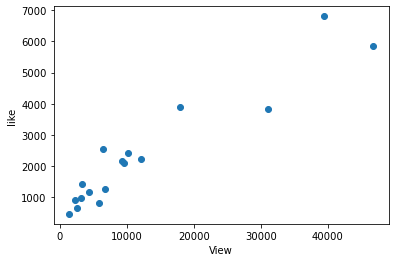

In [30]:
plt.scatter(df['view'], df['like'])
plt.xlabel('View')
plt.ylabel('like')
plt.show()

As you can see in the graph above, the relation between the "like" and the "view" parameters are linear, so we can predict the missing values with linear regression method.

First we need to drop our non-important for learning features such as caption, user_id and etc.

In [44]:
df_like = df.drop(df.columns.difference(['view','like']), 1)
c = [c for c in df_like.columns if c != 'like']
X = df_like[df_like['like'].notnull()].loc[:, c].values
y = df_like[df_like['like'].notnull()]['like'].values
XX = df_like[df_like['like'].isnull()].loc[:, c].values

In the cell above first we need to split our ground truth data with the data we want to predict. For the first iteration of imputation with this method, we will try to impute the "like" amount regarding the "view". This means that our dependent variable is "like" and independent variable is view.

Also I decided to save the other half of this data, the part we are going to predict if this method scores high enough, with the name of XX.

In the next cell we are going to define and implement our regression model to determine this method accuracy regarding imputing the data.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [119]:
kf = KFold(n_splits = 4)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linear_clf = LinearRegression()
    linear_clf.fit(X_train, y_train)
    y_test_pred = linear_clf.predict(X_test)
    
    scores.append(r2_score(y_test, y_test_pred))
    
print('Our R^2 Scores are:')
print(scores)

Our R^2 Scores are:
[0.7514947340121827, -0.0966328629727704, 0.7317753014148566, 0.8580228730669655]


Since our train data is so small, we used K Fold Cross Validation to make our model train better. I used 4 fold and you can see each $R^2$ score in the output of cell above.

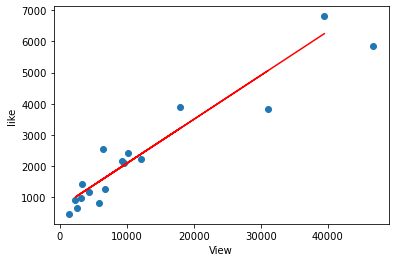

In [120]:
plt.scatter(df['view'], df['like'])
plt.plot(X_train, linear_clf.coef_[0] * X_train + linear_clf.intercept_, '-r')
plt.xlabel('View')
plt.ylabel('like')
plt.show()

In the cell above, we plotted the trained Linear Regression model as red line, it's obvious that this two parameters are corrollated linnearly, but I believe we can use polynomial regression to make this model even more accurate.

In [121]:
prediction = linear_clf.predict(XX)

print(prediction)
print(XX)

[3705.71201153 2694.35683873 2126.40507875 1141.59762622 3903.69022323
 1695.56946968  872.87256425 2909.13919252 2570.37333668 1232.11405539
 2276.0890334  2278.06599129 2244.59891841 2498.63800747 8703.32035003
 7536.35034891 1521.45596394 1727.34200722 1396.90761678 1254.56664859
 2794.61684609 1610.70149162 1463.27691742 1192.85732012 2915.35248875
 3660.80682513 6016.21094161 1322.77169585]
[[21489]
 [14327]
 [10305]
 [ 3331]
 [22891]
 [ 7254]
 [ 1428]
 [15848]
 [13449]
 [ 3972]
 [11365]
 [11379]
 [11142]
 [12941]
 [56880]
 [48616]
 [ 6021]
 [ 7479]
 [ 5139]
 [ 4131]
 [15037]
 [ 6653]
 [ 5609]
 [ 3694]
 [15892]
 [21171]
 [37851]
 [ 4614]]


In [38]:
print(X)
print(y)

[[39495]
 [ 5838]
 [ 6454]
 [ 6684]
 [17999]
 [ 2508]
 [ 3250]
 [ 3199]
 [ 4352]
 [ 9303]
 [10118]
 [ 2298]
 [31048]
 [12112]
 [ 9611]
 [46819]
 [ 1337]]
[39495  5838  6454  6684 17999  2508  3250  3199  4352  9303 10118  2298
 31048 12112  9611 46819  1337]


In [46]:
XX

array([[21489],
       [14327],
       [10305],
       [ 3331],
       [22891],
       [ 7254],
       [ 1428],
       [15848],
       [13449],
       [ 3972],
       [11365],
       [11379],
       [11142],
       [12941],
       [56880],
       [48616],
       [ 6021],
       [ 7479],
       [ 5139],
       [ 4131],
       [15037],
       [ 6653],
       [ 5609],
       [ 3694],
       [15892],
       [21171],
       [37851],
       [ 4614]], dtype=int64)